In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import wandb
import os
from sklearn.decomposition import PCA
import itertools

from collections import Counter

In [2]:
import importlib
import functions as f
# Reload the functions module after updates
importlib.reload(f)

<module 'functions' from 'c:\\Users\\cmdunham\\OneDrive\\Documents\\phd_program\\ChemicalDataGeneration\\models\\functions.py'>

# Loading Data:
---

In [11]:
file_path = '../data/carls/train_carls.feather'
train_carls = pd.read_feather(file_path)
train_carls = train_carls.drop(columns=['level_0'])

file_path = '../data/carls/val_carls.feather'
val_carls = pd.read_feather(file_path)
val_carls = val_carls.drop(columns=['level_0'])

file_path = '../data/carls/test_carls.feather'
test_carls = pd.read_feather(file_path)
test_carls = test_carls.drop(columns=['level_0'])

# file_path='/mnt/usb/cmdunham/preprocessed_ims_data/train_carls_avg_backgrounds.csv'
# train_carls = pd.read_csv(file_path)
# file_path = '/mnt/usb/cmdunham/preprocessed_ims_data/val_carls_avg_backgrounds.csv'
# val_carls = pd.read_csv(file_path)
# file_path='/mnt/usb/cmdunham/preprocessed_ims_data/test_carls_avg_backgrounds.csv'
# test_carls = pd.read_csv(file_path)


# file_path = '/mnt/usb/cmdunham/preprocessed_ims_data/train_carls_dif_backgrounds.csv'
# train_carls = pd.read_csv(file_path)
# file_path = '/mnt/usb/cmdunham/preprocessed_ims_data/val_carls_dif_backgrounds.csv'
# val_carls = pd.read_csv(file_path)
# file_path='/mnt/usb/cmdunham/preprocessed_ims_data/test_carls_dif_backgrounds.csv'
# test_carls = pd.read_csv(file_path)


# file_path = '/mnt/usb/cmdunham/preprocessed_ims_data/train_carls_.csv'
# train_carls = pd.read_csv(file_path)
# file_path = '/mnt/usb/cmdunham/preprocessed_ims_data/val_carls_.csv'
# val_carls = pd.read_csv(file_path)
# file_path='/mnt/usb/cmdunham/preprocessed_ims_data/test_carls_.csv'
# test_carls = pd.read_csv(file_path)

In [5]:
# file_path = '../data/MoNA_embeddings_multiple_instrument_types.csv'
# mass_spec_embeddings = pd.read_csv(file_path)
# mass_spec_embeddings = mass_spec_embeddings.rename(columns={
#     'METHYL PROPIONATE': 'Methyl Propionate', 'DIETHYL MALEATE':'Diethyl Maleate'
#     })

# file_path = '../data/mass_spec_encoder_output.csv'
# mass_spec_encoder_generated_embeddings = pd.read_csv(file_path)

In [14]:
file_path = '../data/name_smiles_embedding_file.csv'
name_smiles_embedding_df = pd.read_csv(file_path)

# set the df index to be the chemical abbreviations in col 'Unnamed: 0'
name_smiles_embedding_df.set_index('Unnamed: 0', inplace=True)
name_smiles_embedding_df.head()

,Name,SMILES,embedding
Unnamed: 0,,,
BKG,Background,NaN,NaN
DEM,Diethyl Malonate,CCOC(=O)CC(=O)OCC,"[0.3809719, 0.0005454039, 0.25539753, -0.24272..."
DEB,"1,2,3,4-Diepoxybutane",C1C(O1)C2CO2,"[0.06318759, 0.009022221, 0.42160067, 0.195722..."
MES,2-(N-morpholino)ethanesulfonic acid,C1COCCN1CCS(=O)(=O)O,"[-0.32520813, 0.009838342, -0.15108328, 0.2845..."
DMMP,Dimethyl methylphosphonate,COP(=O)(C)OC,"[0.12106821, 0.0029424396, -0.14450483, 0.0726..."


In [20]:
# file_path = '../data/mass_spec_data_for_kevin_steven.csv'
# mass_spec_encoder_generated_embeddings = pd.read_csv(file_path)

file_path = '../data/mass_spec_name_smiles_embedding_file.csv'
mass_spec_name_smiles_embedding_df = pd.read_csv(file_path)

# set the df index to be the chemical abbreviations in col 'Unnamed: 0'
mass_spec_name_smiles_embedding_df.set_index('Unnamed: 0', inplace=True)
mass_spec_name_smiles_embedding_df.head()

,SMILES,embedding,Name
Unnamed: 0,,,
"(5R,11R)-5,11-Dimethylpentacosane",CCCCCCCCCCCCCCC(C)CCCCCC(C)CCCC,"[-0.048933726, 0.0017029907, -0.272093, -0.369...","(5R,11R)-5,11-Dimethylpentacosane"
"1,3-Diaminopropane",C(CN)CN,"[-0.22048391, -0.0011410714, 0.06557533, 0.193...","1,3-Diaminopropane"
"1,4-Butanediamine",C(CCN)CN,"[-0.21609126, -0.0005372154, 0.24562673, 0.293...","1,4-Butanediamine"
1-Hexanol,CCCCCCO,"[-0.23157702, 0.0011296304, 0.21073784, -0.179...",1-Hexanol
1-Octanol,CCCCCCCCO,"[-0.2599937, 0.0021180445, 0.109357715, -0.293...",1-Octanol


In [15]:
embedding_floats = []
for chem_name in name_smiles_embedding_df.index:
    if chem_name == 'BKG':
        embedding_floats.append(None)
    else:
        embedding_float = name_smiles_embedding_df['embedding'][chem_name].split('[')[1]
        embedding_float = embedding_float.split(']')[0]
        embedding_float = [np.float32(num) for num in embedding_float.split(',')]
        embedding_floats.append(embedding_float)

name_smiles_embedding_df['Embedding Floats'] = embedding_floats

In [21]:
mass_spec_embedding_floats = []
for chem_name in mass_spec_name_smiles_embedding_df.index:
    embedding_float = mass_spec_name_smiles_embedding_df['embedding'][chem_name].split('[')[1]
    embedding_float = embedding_float.split(']')[0]
    embedding_float = [np.float32(num) for num in embedding_float.split(',')]
    mass_spec_embedding_floats.append(embedding_float)

mass_spec_name_smiles_embedding_df['Embedding Floats'] = mass_spec_embedding_floats

In [22]:
# filtering out chems with < 5 embeddings
# mass_spec_chem_counts = Counter(mass_spec_encoder_generated_embeddings['Label'])
# mass_spec_chem_counts = Counter(mass_spec_encoder_generated_embeddings['chem_name'])
# chems_above_5 = [key for key, count in mass_spec_chem_counts.items() if count >= 5]
filtered_mass_spec_embeddings = pd.DataFrame([emb for emb in mass_spec_name_smiles_embedding_df['Embedding Floats']]).T #mass_spec_embeddings[chems_above_5]
cols = mass_spec_name_smiles_embedding_df.index
filtered_mass_spec_embeddings.columns = cols
# filtered_mass_spec_encoder_generated_embeddings = mass_spec_encoder_generated_embeddings[mass_spec_encoder_generated_embeddings['Label'].isin(chems_above_5)]

# Combine embeddings for IMS simulants and mass spec chems to use for plotting pca
ims_embeddings = pd.DataFrame([emb for emb in name_smiles_embedding_df['Embedding Floats']][1:]).T
cols = name_smiles_embedding_df.index[1:]
ims_embeddings.columns = cols
all_true_embeddings = pd.concat([ims_embeddings, filtered_mass_spec_embeddings], axis=1)
# all_true
all_true_embeddings.head()

Unnamed: 0,DEM,DEB,MES,DMMP,DPM,JP8,TEPO,DtBP,"(5R,11R)-5,11-Dimethylpentacosane","1,3-Diaminopropane",...,Methyl Octadecanoate,Naphthalene,Pentadecane,Phenanthrene,Pyrene,Spermidine,Succinic Acid,Testosterone,Tryptophan,Undecane
0,0.380972,0.063188,-0.325208,0.121068,-0.023968,0.025142,0.193039,0.226090,-0.048934,-0.220484,...,0.169634,0.468407,0.117451,0.579996,0.444973,-0.182377,0.064577,-0.049732,0.188416,0.110121
1,0.000545,0.009022,0.009838,0.002942,0.002720,0.011977,0.000974,0.000808,0.001703,-0.001141,...,0.005854,-0.000690,0.001458,-0.001710,-0.004033,0.002279,0.035474,0.068347,0.001636,0.000952
2,0.255398,0.421601,-0.151083,-0.144505,0.158301,0.542705,0.066288,-0.062160,-0.272093,0.065575,...,-0.123640,0.257259,-0.039999,0.064326,0.064121,0.435218,-0.251742,-0.038517,-0.450764,-0.037651
3,-0.242728,0.195723,0.284503,0.072665,-0.010084,0.364973,-0.195223,-0.045342,-0.369603,0.193559,...,-0.355696,0.331527,-0.441098,0.421061,0.428294,0.452678,0.044983,-0.575486,0.635695,-0.432776
4,-0.305107,-0.167326,-0.099838,-0.107286,-0.067723,-0.236272,-0.272051,-0.075880,-0.023527,-0.015358,...,-0.038613,-0.050993,-0.022548,-0.034104,-0.019335,-0.019928,-0.010587,-0.412169,-0.049434,-0.025410


# Training Encoder on Carls:
---

In [29]:
device = f.set_up_gpu()

Selected GPU ID: 0
  Name: NVIDIA GeForce RTX 4060 Laptop GPU
  Memory Free: 1361.0 MB
  Memory Used: 6597.0 MB
  GPU Load: 0.00%
Current device ID:  cuda:0
PyTorch current device ID: 0
PyTorch current device name: NVIDIA GeForce RTX 4060 Laptop GPU


In [12]:
# file_path = '/mnt/usb/cmdunham/preprocessed_ims_data/train_carls_dif_backgrounds.csv'
# train_embeddings_tensor, train_carl_tensor, train_chem_encodings_tensor, train_carl_indices_tensor = f.create_dataset_tensors_with_dask(file_path, name_smiles_embedding_df, device, carl=True)
# file_path = '/mnt/usb/cmdunham/preprocessed_ims_data/val_carls_dif_backgrounds.csv'
# val_embeddings_tensor, val_carl_tensor, val_chem_encodings_tensor, val_carl_indices_tensor = f.create_dataset_tensors_with_dask(file_path, name_smiles_embedding_df, device, carl=True)
# file_path='/mnt/usb/cmdunham/preprocessed_ims_data/test_carls_dif_backgrounds.csv'
# test_embeddings_tensor, test_carl_tensor, test_chem_encodings_tensor, test_carl_indices_tensor = f.create_dataset_tensors_with_dask(file_path, name_smiles_embedding_df, device, carl=True)

In [16]:
train_embeddings_tensor, train_carl_tensor, train_chem_encodings_tensor, train_carl_indices_tensor = f.create_dataset_tensors(train_carls, name_smiles_embedding_df, device, carl=True)
val_embeddings_tensor, val_carl_tensor, val_chem_encodings_tensor, val_carl_indices_tensor = f.create_dataset_tensors(val_carls, name_smiles_embedding_df, device, carl=True)
test_embeddings_tensor, test_carl_tensor, test_chem_encodings_tensor, test_carl_indices_tensor = f.create_dataset_tensors(test_carls, name_smiles_embedding_df, device, carl=True)

In [17]:
sorted_chem_names = list(train_carls.columns[-8:])
del train_carls, val_carls, test_carls

In [18]:
# Things that need to be changed for each encoder/dataset/target embedding
# notebook_name = '/home/cmdunham/ChemicalDataGeneration/models/carl_encoder.ipynb'
notebook_name = 'C:/Users/cmdunham/OneDrive/Documents/phd_program/ChemicalDataGeneration/models/carl_encoder.ipynb'
architecture = 'carl_encoder'
dataset_type = 'carls'
target_embedding = 'ChemNet'
encoder_path = 'carl_to_chemnet_encoder.pth'

config = {
    'wandb_entity': 'catemerfeld',
    'wandb_project': 'ims_encoder_decoder',
    'gpu':True,
    'threads':1,
}

os.environ['WANDB_NOTEBOOK_NAME'] = notebook_name

In [42]:
# Reload the functions module after updates
importlib.reload(f)

<module 'functions' from 'c:\\Users\\cmdunham\\OneDrive\\Documents\\phd_program\\ChemicalDataGeneration\\models\\functions.py'>

In [ ]:
wandb_kwargs = {
    'architecture': architecture,
    'optimizer':'AdamW',
    'loss':'MSELoss',
    'dataset': dataset_type,
    'target_embedding': target_embedding
}

# sorted_chem_names = list(train_carls.columns[-8:])

model_hyperparams = {
  'batch_size':[32],
  'epochs': [500],
  'learning_rate':[.00001],
  }

train_data = TensorDataset(train_carl_tensor, train_chem_encodings_tensor, train_embeddings_tensor, train_carl_indices_tensor)
val_data = TensorDataset(val_carl_tensor, val_chem_encodings_tensor, val_embeddings_tensor, val_carl_indices_tensor)
test_data = TensorDataset(test_carl_tensor, test_chem_encodings_tensor, test_embeddings_tensor, test_carl_indices_tensor)

best_hyperparams = f.train_model(
    'Encoder', train_data, val_data, test_data, 
    device, config, wandb_kwargs, 
    all_true_embeddings, name_smiles_embedding_df, model_hyperparams, 
    sorted_chem_names, encoder_path, save_emb_pca_to_wandb=True, early_stop_threshold=15,
    input_type='Carl', show_wandb_run_name=True, lr_scheduler=True
    )

In [35]:
best_model = f.Encoder().to(device)
best_model.load_state_dict(torch.load(encoder_path))
encoder_criterion = nn.MSELoss()
print(best_model)

Encoder(
  (encoder): Sequential(
    (0): Linear(in_features=1676, out_features=1548, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Linear(in_features=1548, out_features=1420, bias=True)
    (3): LeakyReLU(negative_slope=0.01, inplace=True)
    (4): Linear(in_features=1420, out_features=1292, bias=True)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
    (6): Linear(in_features=1292, out_features=1164, bias=True)
    (7): LeakyReLU(negative_slope=0.01, inplace=True)
    (8): Linear(in_features=1164, out_features=1036, bias=True)
    (9): LeakyReLU(negative_slope=0.01, inplace=True)
    (10): Linear(in_features=1036, out_features=908, bias=True)
    (11): LeakyReLU(negative_slope=0.01, inplace=True)
    (12): Linear(in_features=908, out_features=780, bias=True)
    (13): LeakyReLU(negative_slope=0.01, inplace=True)
    (14): Linear(in_features=780, out_features=652, bias=True)
    (15): LeakyReLU(negative_slope=0.01, inplace=True)
    (16): Linear(in_f

In [36]:
encoder_path = '../models/best_carl_to_chemnet_encoder.pth'
torch.save(best_model.state_dict(), encoder_path)

## Generating Carl Embedding Predictions:
---

In [ ]:
# file_path='/mnt/usb/cmdunham/preprocessed_ims_data/train_carls_avg_backgrounds.csv'
# train_carls = pd.read_csv(file_path)
# file_path = '/mnt/usb/cmdunham/preprocessed_ims_data/val_carls_avg_backgrounds.csv'
# val_carls = pd.read_csv(file_path)
# file_path='/mnt/usb/cmdunham/preprocessed_ims_data/test_carls_avg_backgrounds.csv'
# test_carls = pd.read_csv(file_path)

# train_embeddings_tensor, train_carl_tensor, train_chem_encodings_tensor, train_carl_indices_tensor = f.create_dataset_tensors(train_carls, name_smiles_embedding_df, device, carl=True)
# val_embeddings_tensor, val_carl_tensor, val_chem_encodings_tensor, val_carl_indices_tensor = f.create_dataset_tensors(val_carls, name_smiles_embedding_df, device, carl=True)
# test_embeddings_tensor, test_carl_tensor, test_chem_encodings_tensor, test_carl_indices_tensor = f.create_dataset_tensors(test_carls, name_smiles_embedding_df, device, carl=True)

In [48]:
encoder_path = '../models/carl_to_chemnet_encoder_used_for_results.pth'
best_model = f.Encoder().to(device)
best_model.load_state_dict(torch.load(encoder_path))
encoder_criterion = nn.MSELoss()

RuntimeError: Attempting to deserialize object on CUDA device 1 but torch.cuda.device_count() is 1. Please use torch.load with map_location to map your storages to an existing device.

In [47]:
del best_model

In [35]:
# # batch_size = best_hyperparams['batch_size']
# batch_size = 32

# train_dataset = DataLoader(
#     TensorDataset(
#         train_carl_tensor, 
#         train_chem_encodings_tensor, 
#         train_embeddings_tensor,
#         train_carl_indices_tensor
#         ), 
#         batch_size=batch_size, 
#         shuffle=False
#         )
# predicted_embeddings, output_name_encodings, average_loss, input_carl_indices = f.predict_embeddings(train_dataset, best_model, device, encoder_criterion)
# input_carl_indices = [idx.cpu().detach().numpy() for idx_list in input_carl_indices for idx in idx_list]
# input_carl_indices = [idx for idx_list in input_carl_indices for idx in idx_list]
# predicted_embeddings = [emb.cpu().detach().numpy() for emb_list in predicted_embeddings for emb in emb_list]
# predicted_embeddings = [emb for emb_list in predicted_embeddings for emb in emb_list]
# output_name_encodings = [enc.cpu().detach().numpy() for enc_list in output_name_encodings for enc in enc_list]
# output_name_encodings = [enc for enc_list in output_name_encodings for enc in enc_list]
# train_preds_df = pd.DataFrame(predicted_embeddings)
# train_preds_df.insert(0, 'index', input_carl_indices)
# name_encodings_df = pd.DataFrame(output_name_encodings)
# name_encodings_df.columns = train_carls.columns[-8:]
name_encodings_df.columns = sorted_chem_names
train_preds_df = pd.concat([train_preds_df, name_encodings_df], axis=1)

In [33]:
# batch_size = best_hyperparams['batch_size']
batch_size = 32

val_dataset = DataLoader(
    TensorDataset(
        val_carl_tensor, 
        val_chem_encodings_tensor, 
        val_embeddings_tensor,
        val_carl_indices_tensor
        ), 
        batch_size=batch_size, 
        shuffle=False
        )
predicted_embeddings, output_name_encodings, average_loss, input_carl_indices = f.predict_embeddings(val_dataset, best_model, device, encoder_criterion)
input_carl_indices = [idx.cpu().detach().numpy() for idx_list in input_carl_indices for idx in idx_list]
predicted_embeddings = [emb.cpu().detach().numpy() for emb_list in predicted_embeddings for emb in emb_list]
output_name_encodings = [enc.cpu().detach().numpy() for enc_list in output_name_encodings for enc in enc_list]
val_preds_df = pd.DataFrame(predicted_embeddings)
val_preds_df.insert(0, 'index', input_carl_indices)
name_encodings_df = pd.DataFrame(output_name_encodings)
name_encodings_df.columns = val_carls.columns[-8:]
val_preds_df = pd.concat([val_preds_df, name_encodings_df], axis=1)

In [ ]:
# batch_size = best_hyperparams['batch_size']
batch_size = 32

test_dataset = DataLoader(
    TensorDataset(
        test_carl_tensor, 
        test_chem_encodings_tensor, 
        test_embeddings_tensor,
        test_carl_indices_tensor
        ), 
        batch_size=best_hyperparams['batch_size'], 
        shuffle=False
        )
predicted_embeddings, output_name_encodings, average_loss, input_carl_indices = f.predict_embeddings(test_dataset, best_model, device, encoder_criterion)
input_carl_indices = [idx.cpu().detach().numpy() for idx_list in input_carl_indices for idx in idx_list]
predicted_embeddings = [emb.cpu().detach().numpy() for emb_list in predicted_embeddings for emb in emb_list]
output_name_encodings = [enc.cpu().detach().numpy() for enc_list in output_name_encodings for enc in enc_list]
test_preds_df = pd.DataFrame(predicted_embeddings)
test_preds_df.insert(0, 'index', input_carl_indices)
name_encodings_df = pd.DataFrame(output_name_encodings)
name_encodings_df.columns = test_carls.columns[-8:]
test_preds_df = pd.concat([test_preds_df, name_encodings_df], axis=1)

In [37]:
file_path = '/mnt/usb/cmdunham/avg_bkg_carl_encoder_train_embeddings.csv'
train_preds_df.to_csv(file_path, index=False)
file_path = '/mnt/usb/cmdunham/avg_bkg_carl_encoder_val_embeddings.csv'
val_preds_df.to_csv(file_path, index=False)
file_path = '/mnt/usb/cmdunham/avg_bkg_carl_encoder_test_embeddings.csv'
test_preds_df.to_csv(file_path, index=False)

In [38]:
encoder_path = '../models/carl_to_chemnet_encoder_used_for_results.pth'
torch.save(best_model.state_dict(), encoder_path)

## Viewing Encoder Results:
---

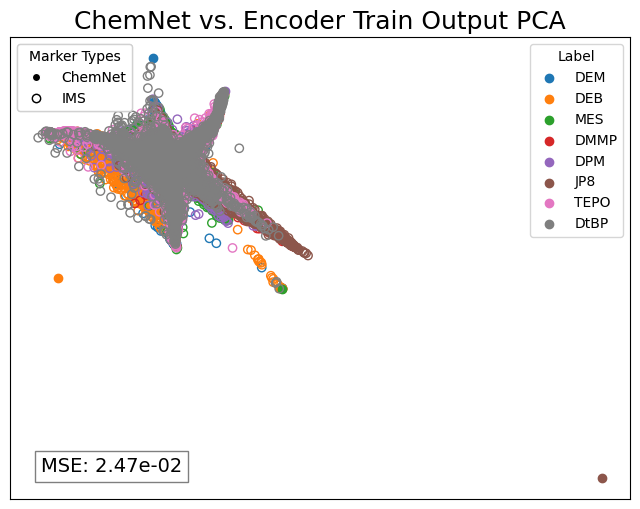

In [43]:
# sorted_chem_names = list(train_carls.columns[-8:])

train_data = TensorDataset(train_carl_tensor, train_chem_encodings_tensor, train_embeddings_tensor, train_carl_indices_tensor)

# batch_size = best_hyperparams['batch_size']
batch_size = 32

f.plot_pca(
    train_data, batch_size, best_model, device, 
    encoder_criterion, sorted_chem_names, all_true_embeddings, 
    name_smiles_embedding_df, 'Train', input_type='IMS', show_wandb_run_name = False, log_wandb=False
    )

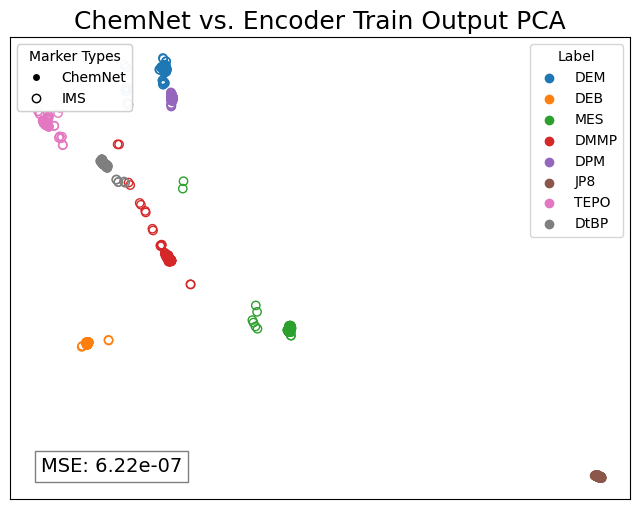

In [36]:
# sorted_chem_names = list(train_carls.columns[-8:])

# train_data = TensorDataset(train_carl_tensor, train_chem_encodings_tensor, train_embeddings_tensor, train_carl_indices_tensor)

# # batch_size = best_hyperparams['batch_size']
# batch_size = 32

f.plot_pca(
    train_data, batch_size, best_model, device, 
    encoder_criterion, sorted_chem_names, all_true_embeddings, 
    name_smiles_embedding_df, 'Train', input_type='IMS', show_wandb_run_name = False, log_wandb=False
    )

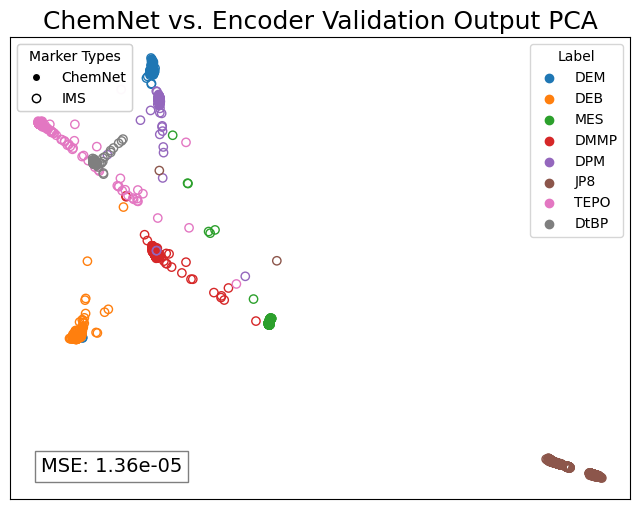

In [35]:
sorted_chem_names = list(val_carls.columns[-8:])

val_data = TensorDataset(val_carl_tensor, val_chem_encodings_tensor, val_embeddings_tensor, val_carl_indices_tensor)

# batch_size = best_hyperparams['batch_size']
batch_size = 32

f.plot_pca(
    val_data, batch_size, best_model, device, 
    encoder_criterion, sorted_chem_names, all_true_embeddings, 
    name_smiles_embedding_df, 'Validation', input_type='IMS', show_wandb_run_name = False, log_wandb=False
    )

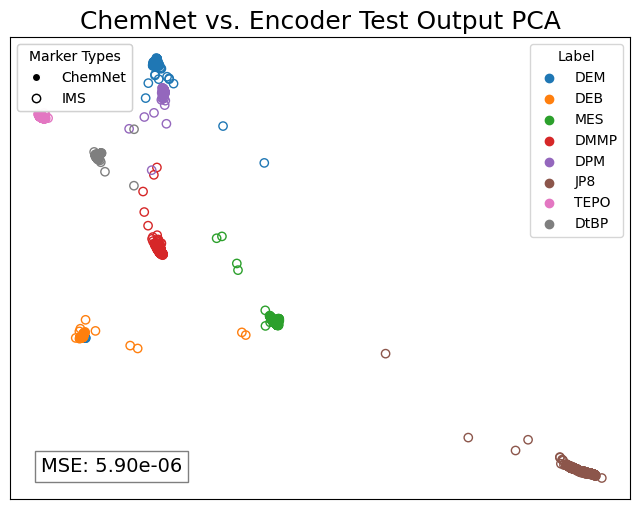

In [ ]:
sorted_chem_names = list(test_carls.columns[-8:])

test_data = TensorDataset(test_carl_tensor, test_chem_encodings_tensor, test_embeddings_tensor, test_carl_indices_tensor)

# batch_size = best_hyperparams['batch_size']
batch_size = 32

f.plot_pca(
    test_data, batch_size, best_model, device, 
    encoder_criterion, sorted_chem_names, all_true_embeddings, 
    name_smiles_embedding_df, 'Test', input_type='IMS', show_wandb_run_name = False, log_wandb=False
    )

# Unused Code:
---

In [ ]:
# # Calling plot_emb_pca directly without going through plot_pca. Buggy.
# dataset = DataLoader(
#         data, 
#         batch_size=batch_size, 
#         shuffle=False
#     )

# preds, name_encodings, avg_loss, _ = f.predict_embeddings(dataset, model, device, encoder_criterion)
# true_embeddings, predicted_embeddings_flattened, chem_names = preds_to_emb_pca_plot(
#     preds, name_encodings, sorted_chem_names, ims_embeddings_df,  
#     )
# preds_df = pd.DataFrame(predicted_embeddings_flattened)
# preds_df['Label'] = chem_names

# f.plot_emb_pca(
#     all_true_embeddings, preds_df, results_type='Test', input_type='IMS',
#     chemnet_embeddings_to_plot=true_embeddings, log_wandb=False, mse_insert=avg_loss,
#     show_wandb_run_name=False
#     )

Train Loss:  1.1961571237917794e-05


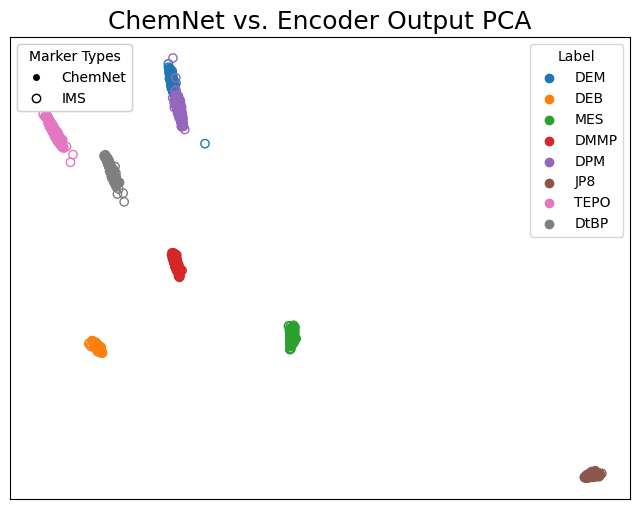

In [ ]:
# train_dataset = DataLoader(
#     TensorDataset(
#         train_carl_tensor, 
#         train_chem_encodings_tensor, 
#         train_embeddings_tensor,
#         train_carl_indices_tensor,
#         ), 
#         batch_size=best_hyperparams['batch_size'], 
#         shuffle=True
#         )
# train_preds, train_name_encodings, train_avg_loss, train_input_carl_indices = predict_embeddings(train_dataset, encoder, device, encoder_criterion)
# train_true_embeddings, train_predicted_embeddings_flattened, train_chem_names = preds_to_emb_pca_plot(
#     train_preds, train_name_encodings, sorted_chem_names, name_smiles_embedding_df,  
#     )
# train_preds_df = pd.DataFrame(train_predicted_embeddings_flattened)
# train_preds_df['Label'] = train_chem_names

# print('Train Loss: ', train_avg_loss)
# plot_emb_pca(all_true_embeddings, train_preds_df, log_wandb=False, chemnet_embeddings_to_plot=train_true_embeddings)


Validation Loss:  6.433723416225333e-05


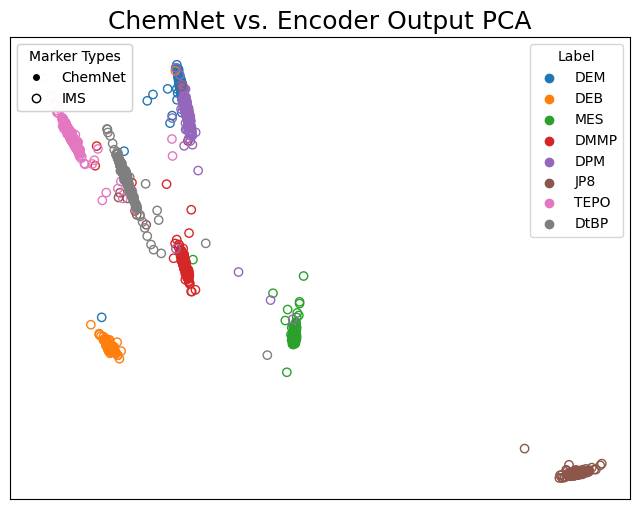

In [ ]:
# val_dataset = DataLoader(
#     TensorDataset(
#         val_carl_tensor, 
#         val_chem_encodings_tensor, 
#         val_embeddings_tensor,
#         val_carl_indices_tensor
#         ), 
#         batch_size=best_hyperparams['batch_size'], 
#         shuffle=False
#         )

# val_preds, val_name_encodings, val_avg_loss, val_input_carl_indices = predict_embeddings(val_dataset, encoder, device, encoder_criterion)
# val_true_embeddings, val_predicted_embeddings_flattened, val_chem_names = preds_to_emb_pca_plot(
#     val_preds, val_name_encodings, sorted_chem_names, name_smiles_embedding_df,  
#     )
# val_preds_df = pd.DataFrame(val_predicted_embeddings_flattened)
# val_preds_df['Label'] = val_chem_names

# print('Validation Loss: ', val_avg_loss)
# plot_emb_pca(all_true_embeddings, val_preds_df, log_wandb=False, chemnet_embeddings_to_plot=train_true_embeddings)

Test Loss:  4.781812557635492e-05


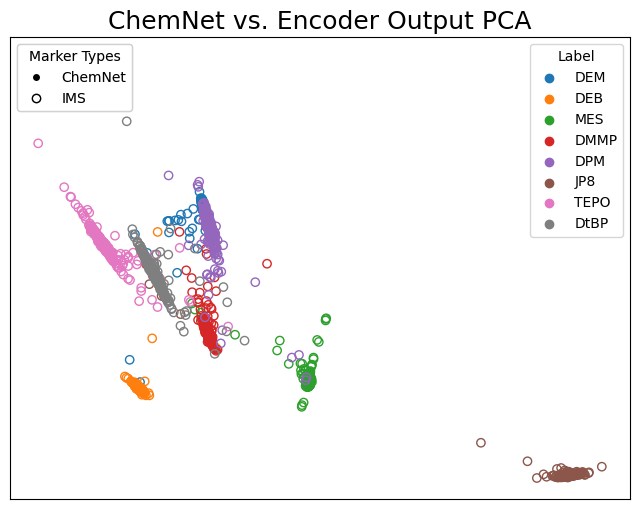

In [ ]:
# test_dataset = DataLoader(
#     TensorDataset(
#     test_carl_tensor, 
#     test_chem_encodings_tensor, 
#     test_embeddings_tensor,
#     test_carl_indices_tensor
#     ), 
#     batch_size=best_hyperparams['batch_size'], 
#     shuffle=False
#     )

# test_preds, test_name_encodings, test_avg_loss, test_input_carl_indices = predict_embeddings(test_dataset, encoder, device, encoder_criterion)
# test_true_embeddings, test_predicted_embeddings_flattened, test_chem_names = preds_to_emb_pca_plot(
#     test_preds, test_name_encodings, sorted_chem_names, name_smiles_embedding_df,  
#     )
# test_preds_df = pd.DataFrame(test_predicted_embeddings_flattened)
# test_preds_df['Label'] = test_chem_names

# print('Test Loss: ', test_avg_loss)
# plot_emb_pca(all_true_embeddings, test_preds_df, log_wandb=False, chemnet_embeddings_to_plot=train_true_embeddings)

## Saving Carl Embeddings:
---

In [ ]:
# # saving carl embeddings to files
# train_input_carl_indices_list = [idx.cpu().detach().numpy() for idx_list in train_input_carl_indices for idx in idx_list]
# train_preds_df['index'] = train_input_carl_indices_list
# file_path = '/mnt/usb/cmdunham/carl_encoder_train_embeddings.csv'
# train_preds_df.to_csv(file_path, index=False)

# val_input_carl_indices_list = [idx.cpu().detach().numpy() for idx_list in val_input_carl_indices for idx in idx_list]
# val_preds_df['index'] = val_input_carl_indices_list
# file_path = '/mnt/usb/cmdunham/carl_encoder_val_embeddings.csv'
# val_preds_df.to_csv(file_path, index=False)

# test_input_carl_indices_list = [idx.cpu().detach().numpy() for idx_list in test_input_carl_indices for idx in idx_list]
# test_preds_df['index'] = test_input_carl_indices_list
# file_path = '/mnt/usb/cmdunham/carl_encoder_test_embeddings.csv'
# test_preds_df.to_csv(file_path, index=False)

## Definitions:
---

In [ ]:
def flatten_and_bin(predicted_embeddings_batches):
    # Function to flatten the list of prediction batches and make each prediction binary
    binary_preds_list = []
    
    for batch in predicted_embeddings_batches:
        for encoding in batch:
            # Get the index of the maximum value
            max_index = torch.argmax(encoding)
            # Create a binary label with 1 in the index of the highest value's index in the encoding 0s in all other indices
            binary_pred = [0] * len(encoding)
            binary_pred[max_index] = 1
            binary_preds_list.append(binary_pred)
    
    return binary_preds_list

In [ ]:
def run_with_wandb(config, **kwargs):
    config.update(kwargs)

    wandb.init(entity=config['wandb_entity'],
               project=config['wandb_project'],
               config=config)

    # Set the number of threads
    torch.set_num_threads(config['threads'])

    # Find out is there is a GPU available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if not config['gpu']:
        device = torch.device('cpu')
    print(f'Using device: {device}')

In [ ]:
def update_wandb_kwargs(wandb_kwargs, updates):
    for key in updates.keys():
        wandb_kwargs[key] = updates[key]
    return wandb_kwargs

In [ ]:
def train_one_epoch(train_dataset, device, model, criterion, optimizer, epoch, combo):
  epoch_training_loss = 0

  predicted_embeddings = []
  output_name_encodings = []

  for batch, name_encodings, true_embeddings, _ in train_dataset:
    # move inputs to device
    batch = batch.to(device)
    name_encodings = name_encodings.to(device)
    true_embeddings = true_embeddings.to(device)

    # backprapogation
    optimizer.zero_grad()

    # forward pass
    batch_predicted_embeddings = model(batch)

    loss = criterion(batch_predicted_embeddings, true_embeddings)
    # accumulate epoch training loss
    epoch_training_loss += loss.item()

    loss.backward()
    optimizer.step()

    # at last epoch store output embeddings and corresponding labels to output list
    if (epoch + 1) == combo['epochs']:
      output_name_encodings.append(name_encodings)
      predicted_embeddings.append(batch_predicted_embeddings)

  # divide by number of batches to calculate average loss
  average_loss = epoch_training_loss/len(train_dataset)
  if (epoch + 1) == combo['epochs']:
    return average_loss, predicted_embeddings, output_name_encodings
  else:
    return average_loss

In [ ]:
def preds_to_emb_pca_plot(
        predicted_embeddings, output_name_encodings, 
        sorted_chem_names, emb_df, 
        mass_spec_encoder_embeddings=False, mass_spec_chems=False
        ):
    """
    Generate and plot a PCA visualization of predicted embeddings against corresponding ChemNet embeddings.

    Parameters:
    ----------
    predicted_embeddings : list of list of torch.Tensor
        A nested list of predicted embeddings, where each inner list contains tensors for a batch.

    output_name_encodings : list of list of torch.Tensor
        A nested list of one-hot encoded tensors representing the chemical names for the predicted embeddings.

    sorted_chem_names : list of str
        A list of chemical names corresponding to the indices of the one-hot encodings.

    emb_df : pandas.DataFrame
        A DataFrame containing true embeddings, with 'Embedding Floats' as one of its columns.

    log_wandb : boolean 
        True - log plot to wandb. False - do not log plot to wandb.

    Returns:
    -------
    A tuple containing:
    - true_embeddings (pd.DataFrame): DataFrame of true embeddings used for comparison.
    - predicted_embeddings_flattened (list): Flattened list of predicted embeddings.
    - chem_names (list): List of chemical names corresponding to the predicted embeddings.
    """

    # Currently, preds and name encodings are lists of [n_batches, batch_size], flattening to lists of [n_samples]
    predicted_embeddings_flattened = [emb.cpu().detach().numpy() for emb_list in predicted_embeddings for emb in emb_list]
    chem_name_encodings_flattened = [enc.cpu() for enc_list in output_name_encodings for enc in enc_list]

    # Get chemical names from encodings
    chem_names = [sorted_chem_names[list(encoding).index(1)] for encoding in chem_name_encodings_flattened]

    if mass_spec_encoder_embeddings:
        for emb in mass_spec_encoder_embeddings:
            predicted_embeddings_flattened.append(torch.Tensor(emb))
        chem_names += mass_spec_chems

    try:
        # making list of all embeddings and chem names except for BKG
        embeddings = [emb for emb in emb_df['Embedding Floats']][1:]
        cols = emb_df.index[1:]
        true_embeddings = pd.DataFrame(embeddings).T
        true_embeddings.columns = cols
        
    except KeyError as e:
        if str(e) == "'Embedding Floats'":
            true_embeddings = emb_df
    
    return (true_embeddings, predicted_embeddings_flattened, chem_names)

In [ ]:
def predict_embeddings(dataset, model, device, criterion):
    total_loss = 0

    model.eval() # Set model to evaluation mode
    predicted_embeddings = []
    output_name_encodings = []
    input_spectra_indices = []

    with torch.no_grad():
        for batch, name_encodings, true_embeddings, spectra_indices in dataset:
            batch = batch.to(device)
            true_embeddings = true_embeddings.to(device)

            batch_predicted_embeddings = model(batch)
            predicted_embeddings.append(batch_predicted_embeddings)
            output_name_encodings.append(name_encodings)
            input_spectra_indices.append(spectra_indices)

            # print(batch_predicted_embeddings.shape, true_embeddings.shape)

            loss = criterion(batch_predicted_embeddings, true_embeddings)
            # accumulate loss
            total_loss += loss.item()

    # divide by number of batches to calculate average loss
    average_loss = total_loss/len(dataset)
    return predicted_embeddings, output_name_encodings, average_loss, input_spectra_indices

In [ ]:
def plot_emb_pca(
        all_embeddings, ims_embeddings, input_type, embedding_type=None, mass_spec_embeddings = None, log_wandb=False, 
        chemnet_embeddings_to_plot=None, mse_insert=None, insert_position=[0.05, 0.05], show_wandb_run_name=True):
    """
    Perform PCA on chemical embeddings and plot the transformed data, including IMS and Mass Spec embeddings if provided.

    Parameters:
    ----------
    all_embeddings : pd.DataFrame
        A dataframe containing ChemNet embeddings for all chemicals. 
        Each column represents one chemical's ChemNet embedding.
    ims_embeddings : pd.DataFrame
        A dataframe containing IMS (ion mobility spectrometry) embeddings. Must include a 'Label' column
        with chemical names and additional columns for embedding features.
    mass_spec_embeddings : pd.DataFrame, optional
        A dataframe containing mass spectrometry embeddings. Similar structure to `ims_embeddings`.
        Default is None, meaning mass spec embeddings are not included.
    log_wandb : bool, optional
        If True, logs the generated plot to Weights and Biases (wandb). Default is True.
    chemnet_embeddings_to_plot : pd.DataFrame, optional
        A dataframe containing ChemNet embeddings for all chemicals TO BE PLOTTED. 
        Each column represents one chemical's ChemNet embedding.

    Returns:
    -------
    None
        Displays the PCA scatter plot with ChemNet, IMS, and Mass Spec embeddings. 
        Optionally logs the plot to wandb if `log_wandb` is True.

    Notes:
    -----
    - PCA is performed on the transpose of `all_embeddings` so that embeddings for ims and mass spec data can be plotted to the same space.
    """ 
    pca = PCA(n_components=2)
    pca.fit(all_embeddings.T)

    if chemnet_embeddings_to_plot is not None:
        transformed_embeddings = pca.transform(chemnet_embeddings_to_plot.T)
        all_chemical_names = list(chemnet_embeddings_to_plot.columns)
    else:
        transformed_embeddings = pca.transform(all_embeddings.T) 
        all_chemical_names = list(all_embeddings.columns)

    _, ax = plt.subplots(figsize=(8,6))

    # Create a color cycle for distinct colors
    color_cycle = plt.gca()._get_lines.prop_cycler

    ims_labels = list(ims_embeddings['Label'])
    if mass_spec_embeddings is not None:
        mass_spec_labels=list(mass_spec_embeddings['Label'])
    else:
        mass_spec_labels = False
    
    # Scatter plot
    for chem in all_chemical_names:
        idx = all_chemical_names.index(chem)
        color = next(color_cycle)['color']
        # only label 1st 8 chemicals to avoid giant legend
        # ax.scatter(0,0, color = color, label=chem)
        if idx < 8:
            ax.scatter(transformed_embeddings[idx, 0], transformed_embeddings[idx, 1], color = color, label=chem)#, s=200)
        else:
            ax.scatter(transformed_embeddings[idx, 0], transformed_embeddings[idx, 1], color = color)#, s=75)
        # Transform ims_embeddings for the current chemical, if we have ims data for chem
        if chem in ims_labels:
            # transform all data for the given chemical. Exclude last col (label)
            ims_transformed = pca.transform(ims_embeddings[ims_embeddings['Label'] == chem].iloc[:, :-1])
            
            # Scatter plot for ims_embeddings with a different marker
            ax.scatter(ims_transformed[:, 0], ims_transformed[:, 1], marker='o', facecolors='none', edgecolors=color)#marker='x', color=color)#, s=75)
        # repeat for mass spec
        if mass_spec_labels:
            if chem in mass_spec_labels:
                # transform all data for the given chemical. Exclude last col (label)
                mass_spec_transformed = pca.transform(mass_spec_embeddings[mass_spec_embeddings['Label'] == chem].iloc[:, :-1].values)
                
                # Scatter plot for mass_spec_embeddings with a different marker
                ax.scatter(mass_spec_transformed[:, 0], mass_spec_transformed[:, 1], marker='*', color=color, s=75)
    # Add legend
    legend1 = ax.legend(loc='upper right', title='Label')
    ax.add_artist(legend1)

    marker_legends = [
    plt.Line2D([0], [0], marker='o', color='w', label=embedding_type, markerfacecolor='black', markersize=6),
    plt.Line2D([0], [0], marker='o', color='w', label="IMS", markerfacecolor='none', markeredgecolor='black', markersize=6),
    ]
    
    if mass_spec_embeddings is not None:
        marker_legends.append(plt.Line2D([0], [0], marker='*', color='w', label='Mass Spec', markerfacecolor='black', markersize=10))

    # Add the second legend
    legend2 = ax.legend(handles=marker_legends, title='Marker Types', loc='upper left')
    ax.add_artist(legend2)

    if mse_insert is not None:
        # Add mse text in the corner with a box
        plt.text(insert_position[0], insert_position[1], f'MSE: {format(mse_insert, ".2e")}', 
            transform=plt.gca().transAxes,  # Use axis coordinates
            fontsize=14,
            verticalalignment='bottom',  # Align text to the top
            horizontalalignment='left',  # Align text to the right
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))  # Box properties
    
    if show_wandb_run_name == True:
        run_name = wandb.run.name
        # Add wandb run text in the corner
        xlim = plt.xlim()
        ylim = plt.ylim()
        plt.text(xlim[1] - 0.01 * (xlim[1] - xlim[0]),  # x position with an offset
                ylim[0] + 0.01 * (ylim[1] - ylim[0]),  # y position with an offset
                f'WandB run: {run_name}', 
                fontsize=8,
                verticalalignment='bottom',  # Align text to the top
                horizontalalignment='right',  # Align text to the right
                bbox=dict(facecolor='white', alpha=0.001, edgecolor='white'))

    plt.xticks([])
    plt.yticks([])
    if embedding_type != 'ChemNet':
        plt.title(f'{embedding_type} vs. {input_type} Encoder Output PCA', fontsize=18)
    else:
        plt.title(f'ChemNet vs. {input_type} Encoder Output PCA', fontsize=18)

    if log_wandb:
        plt.savefig('tmp_plot.png', format='png', dpi=300)
        wandb.log({'PCA of Predicted Chemical Embeddings': wandb.Image('tmp_plot.png')})

    plt.show()

In [ ]:
def plot_pca(
    data, batch_size, model, device, encoder_criterion, sorted_chem_names, 
    all_embeddings_df, ims_embeddings_df, 
    input_type, embedding_type='ChemNet',
    show_wandb_run_name=True, log_wandb=True, 
    ):
    dataset = DataLoader(
        data, 
        batch_size=batch_size, 
        shuffle=False
    )

    preds, name_encodings, avg_loss, _ = predict_embeddings(dataset, model, device, encoder_criterion)
    true_embeddings, predicted_embeddings_flattened, chem_names = preds_to_emb_pca_plot(
        preds, name_encodings, sorted_chem_names, ims_embeddings_df,  
        )
    preds_df = pd.DataFrame(predicted_embeddings_flattened)
    preds_df['Label'] = chem_names
    
    plot_emb_pca(
        all_embeddings_df, preds_df, input_type=input_type, 
        embedding_type=embedding_type, log_wandb=log_wandb, 
        chemnet_embeddings_to_plot=true_embeddings, mse_insert=avg_loss,
        show_wandb_run_name=show_wandb_run_name
        )

In [ ]:
class Encoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = nn.Sequential(
      nn.Linear(1676,1548),
      nn.LeakyReLU(inplace=True),
      nn.Linear(1548,1420),
      nn.LeakyReLU(inplace=True),
      nn.Linear(1420, 1292),
      nn.LeakyReLU(inplace=True),
      nn.Linear(1292, 1164),
      nn.LeakyReLU(inplace=True),
      nn.Linear(1164, 1036),
      nn.LeakyReLU(inplace=True),
      nn.Linear(1036, 908),
      nn.LeakyReLU(inplace=True),
      nn.Linear(908, 780),
      nn.LeakyReLU(inplace=True),
      nn.Linear(780, 652),
      nn.LeakyReLU(inplace=True),
      nn.Linear(652, 512),
    )

  def forward(self, x):
    x = self.encoder(x)
    return x

In [ ]:
def train_model(
        model_type, train_data, val_data, test_data, device, config, wandb_kwargs, 
        all_embeddings_df, ims_embeddings_df, model_hyperparams, sorted_chem_names, 
        encoder_path, save_emb_pca_to_wandb = True, early_stop_threshold=10, 
        embedding_type='ChemNet', show_wandb_run_name=True
        ):

    # loss to compare for each model. Starting at infinity so it will be replaced by first model's first epoch loss 
    lowest_val_loss = np.inf

    keys = model_hyperparams.keys()
    values = model_hyperparams.values()

    # Generate all parameter combinations from model_config using itertools.product
    combinations = itertools.product(*values)

    # Iterate through each parameter combination and run model 
    for combo in combinations:
        if model_type == 'Encoder':
            encoder = Encoder().to(device)
        epochs_without_validation_improvement = 0
        combo = dict(zip(keys, combo))

        train_dataset = DataLoader(train_data, batch_size=combo['batch_size'], shuffle=True)
        val_dataset = DataLoader(val_data, batch_size=combo['batch_size'], shuffle=False)

        encoder_optimizer = torch.optim.AdamW(encoder.parameters(), lr = combo['learning_rate'])
        encoder_criterion = nn.MSELoss()

        wandb_kwargs = update_wandb_kwargs(wandb_kwargs, combo)

        run_with_wandb(config, **wandb_kwargs)

        print('--------------------------')
        print('--------------------------')
        print('New run with hyperparameters:')
        for key in combo:
            print(key, ' : ', combo[key])

        for epoch in range(combo['epochs']):
            if epochs_without_validation_improvement < early_stop_threshold:
                encoder.train(True)

                # do a pass over the data
                # at last epoch get predicted embeddings and chem names
                if (epoch + 1) == combo['epochs']:
                    average_loss, _, _ = train_one_epoch(
                    train_dataset, device, encoder, encoder_criterion, encoder_optimizer, epoch, combo
                    )
                    # save output pca to weights and biases
                    if save_emb_pca_to_wandb:
                        # plot_pca gets predictions from trained model and plots them
                        plot_pca(
                            train_data, combo['batch_size'], encoder, device, 
                            encoder_criterion, sorted_chem_names, all_embeddings_df, 
                            ims_embeddings_df, 'Train', embedding_type, show_wandb_run_name
                            )
                        plot_pca(
                            test_data, combo['batch_size'], encoder, device, 
                            encoder_criterion, sorted_chem_names, all_embeddings_df,
                            ims_embeddings_df, 'Test', embedding_type, show_wandb_run_name
                            )
                else:
                    average_loss = train_one_epoch(
                    train_dataset, device, encoder, encoder_criterion, encoder_optimizer, epoch, combo
                    )

                epoch_val_loss = 0  
                # evaluate model on validation data
                encoder.eval() # Set model to evaluation mode
                with torch.no_grad():
                    for val_batch, val_name_encodings, val_true_embeddings, _ in val_dataset:
                        val_batch = val_batch.to(device)
                        val_name_encodings = val_name_encodings.to(device)
                        val_true_embeddings = val_true_embeddings.to(device)

                        val_batch_predicted_embeddings = encoder(val_batch)

                        val_loss = encoder_criterion(val_batch_predicted_embeddings, val_true_embeddings)
                        # accumulate epoch validation loss
                        epoch_val_loss += val_loss.item()

                # divide by number of batches to calculate average loss
                val_average_loss = epoch_val_loss/len(val_dataset)

                if val_average_loss < lowest_val_loss:
                    lowest_val_loss = val_average_loss
                    best_epoch = epoch + 1  # Store the best epoch
                    # Save the model state
                    torch.save(encoder.state_dict(), encoder_path)
                    best_hyperparams = combo
                    print(f'Saved best model at epoch {best_epoch}')
                    epochs_without_validation_improvement = 0
                
                else:
                    epochs_without_validation_improvement += 1
                # log losses to wandb
                wandb.log({"Encoder Training Loss": average_loss, "Encoder Validation Loss": val_average_loss})

                if (epoch + 1) % 10 == 0:
                    print('Epoch[{}/{}]:'.format(epoch+1, combo['epochs']))
                    print(f'   Training loss: {average_loss}')
                    print(f'   Validation loss: {val_average_loss}')
                    print('-------------------------------------------')
            else:
                print(f'Validation loss has not improved in {epochs_without_validation_improvement} epochs. Stopping training at epoch {epoch}.')
                wandb.log({'Early Stopping Ecoch':epoch})
                plot_pca(
                    train_data, combo['batch_size'], encoder, device, 
                    encoder_criterion, sorted_chem_names, all_embeddings_df, 
                    ims_embeddings_df, 'Train', embedding_type, show_wandb_run_name
                    )
                plot_pca(
                    test_data, combo['batch_size'], encoder, device, 
                    encoder_criterion, sorted_chem_names, all_embeddings_df,
                    ims_embeddings_df, 'Test', embedding_type, show_wandb_run_name
                    )
                break
        # if save_emb_pca_to_wandb:
        #     # true_embeddings, predicted_embeddings_flattened, chem_names = 
        #     preds_to_emb_pca_plot(predicted_embeddings, output_name_encodings, sorted_chem_names, embedding_df)

        # at last epoch print model architecture details (this will also show up in wandb log)
        print('-------------------------------------------')
        print('-------------------------------------------')
        print('Dataset: ', wandb_kwargs['dataset'])
        print('Target Embeddings: ', wandb_kwargs['target_embedding'])
        print('-------------------------------------------')
        print('-------------------------------------------')
        print(encoder)
        print('-------------------------------------------')
        print('-------------------------------------------')

        wandb.finish()

    print('Hyperparameters for best model: ')
    for key in best_hyperparams:
        print('   ', key, ' : ', best_hyperparams[key])
    
    return best_hyperparams


In [ ]:
def create_dataset_tensors(spectra_dataset, embedding_df, device, carl=False):
    # drop first two cols ('Unnamed:0' and 'index') and last 9 cols ('Label' and OneHot encodings) to get just spectra
    if carl: # carl dataset has no 'Unnamed: 0' column
        spectra = spectra_dataset.iloc[:,1:-9]
    else:
        spectra = spectra_dataset.iloc[:,2:-9]
    chem_encodings = spectra_dataset.iloc[:,-8:]

    # create tensors of spectra, true embeddings, and chemical name encodings for train and val
    chem_labels = list(spectra_dataset['Label'])
    embeddings_tensor = torch.Tensor([embedding_df['Embedding Floats'][chem_name] for chem_name in chem_labels]).to(device)
    spectra_tensor = torch.Tensor(spectra.values).to(device)
    chem_encodings_tensor = torch.Tensor(chem_encodings.values).to(device)
    spectra_indices_tensor = torch.Tensor(spectra_dataset['index'].to_numpy()).to(device)

    return embeddings_tensor, spectra_tensor, chem_encodings_tensor, spectra_indices_tensor

## Other:
---

In [ ]:
# set var deciding if embedding pca plot for this run is saved to wandb
save_emb_pca_to_wandb = True

# Last 8 cols of the df are the chem names
sorted_chem_names = list(train_carls.columns[-8:])

model_config = {
  'batch_size':[128],
  'epochs': [100],
  'learning_rate':[.00001]
  }

# loss to compare for each model. Starting at something high so it will be replaced by first model's loss 
lowest_loss = 100

# model_config = {
#     'batch_size': [128],
#     'epochs': [10],
#     'learning_rate': [.00001]
# }

keys = model_config.keys()
values = model_config.values()

# Generate all parameter combinations from model_config using itertools.product
combinations = itertools.product(*values)

# Iterate through each parameter combination and run model 
for combo in combinations:
  combo = dict(zip(keys, combo))

  train_dataset = DataLoader(TensorDataset(train_carl_tensor, train_chem_encodings_tensor, train_embeddings_tensor, train_carl_indices_tensor), batch_size=combo['batch_size'], shuffle=True)
  val_dataset = DataLoader(TensorDataset(val_carl_tensor, val_chem_encodings_tensor, val_embeddings_tensor, val_carl_indices_tensor), batch_size=combo['batch_size'], shuffle=False)
  encoder = Encoder().to(device)

  encoder_optimizer = torch.optim.AdamW(encoder.parameters(), lr = combo['learning_rate'])
  encoder_criterion = nn.MSELoss()

  wandb_kwargs = {
    'learning_rate': combo['learning_rate'],
    'epochs': combo['epochs'],
    'batch_size': combo['batch_size'],
    'model_architecture': 'carl_encoder',
    'optimizer':'AdamW',
    'loss': 'MSELoss'
  }

  run_with_wandb(config, **wandb_kwargs)

  print('--------------------------')
  print('--------------------------')
  print('New run with hyperparameters:')
  for key in combo:
    print(key, ' : ', combo[key])

  for epoch in range(combo['epochs']):
    # Set model to training mode
    encoder.train(True)

    # do a pass over the data
    # at last epoch get predicted embeddings and chem names
    if (epoch + 1) == combo['epochs']:
      average_loss, predicted_embeddings, output_name_encodings = train_one_epoch(
        train_dataset, device, encoder, encoder_criterion, encoder_optimizer, epoch, combo
        )
    else:
      average_loss = train_one_epoch(
        train_dataset, device, encoder, encoder_criterion, encoder_optimizer, epoch, combo
        )

    epoch_val_loss = 0  
    # evaluate model on validation data
    encoder.eval() # Set model to evaluation mode
    with torch.no_grad():
      for val_batch, val_name_encodings, val_true_embeddings, val_spectra_indices in val_dataset:
        val_batch = val_batch.to(device)
        val_name_encodings = val_name_encodings.to(device)
        val_true_embeddings = val_true_embeddings.to(device)

        val_batch_predicted_embeddings = encoder(val_batch)

        val_loss = encoder_criterion(val_batch_predicted_embeddings, val_true_embeddings)
        # accumulate epoch validation loss
        epoch_val_loss += val_loss.item()

    # divide by number of batches to calculate average loss
    val_average_loss = epoch_val_loss/len(val_dataset)

    # log losses to wandb
    wandb.log({"Encoder Training Loss": average_loss, "Encoder Validation Loss": val_average_loss})
    # wandb.log({"Encoder Training Loss": average_loss})

    if (epoch + 1) % 10 == 0:
      print('Epoch[{}/{}]:'.format(epoch+1, combo['epochs']))
      print(f'   Training loss: {average_loss}')
      print(f'   Validation loss: {val_average_loss}')
      print('-------------------------------------------')

  if save_emb_pca_to_wandb:
    true_embeddings, predicted_embeddings_flattened, chem_names = preds_to_emb_pca_plot(predicted_embeddings, output_name_encodings, sorted_chem_names, name_smiles_embedding_df)

  if average_loss < lowest_loss:
    best_hyperparams = combo

  wandb.finish()

print('Hyperparameters for best model: ')
for key in best_hyperparams:
  print('   ', key, ' : ', best_hyperparams[key])

In [ ]:
def predict_embeddings(dataset, model, device, criterion):
    total_loss = 0

    model.eval() # Set model to evaluation mode
    predicted_embeddings = []
    output_name_encodings = []
    input_spectra_indices = []

    with torch.no_grad():
        for batch, name_encodings, true_embeddings, spectra_indices in dataset:
            batch = batch.to(device)
            true_embeddings = true_embeddings.to(device)

            batch_predicted_embeddings = model(batch)
            predicted_embeddings.append(batch_predicted_embeddings)
            output_name_encodings.append(name_encodings)
            input_spectra_indices.append(spectra_indices)

            loss = criterion(batch_predicted_embeddings, true_embeddings)
            # accumulate loss
            total_loss += loss.item()

    # divide by number of batches to calculate average loss
    average_loss = total_loss/len(dataset)
    return predicted_embeddings, output_name_encodings, average_loss, input_spectra_indices

In [ ]:
def preds_to_emb_pca_plot(predicted_embeddings, output_name_encodings, sorted_chem_names, emb_df, mass_spec_encoder_embeddings=False, mass_spec_chems=False):
    """
    Generate and plot a PCA visualization of predicted embeddings against corresponding ChemNet embeddings.

    Parameters:
    ----------
    predicted_embeddings : list of list of torch.Tensor
        A nested list of predicted embeddings, where each inner list contains tensors for a batch.

    output_name_encodings : list of list of torch.Tensor
        A nested list of one-hot encoded tensors representing the chemical names for the predicted embeddings.

    sorted_chem_names : list of str
        A list of chemical names corresponding to the indices of the one-hot encodings.

    emb_df : pandas.DataFrame
        A DataFrame containing true embeddings, with 'Embedding Floats' as one of its columns.

    log_wandb : boolean 
        True - log plot to wandb. False - do not log plot to wandb.

    Returns:
    -------
    A tuple containing:
    - true_embeddings (pd.DataFrame): DataFrame of true embeddings used for comparison.
    - predicted_embeddings_flattened (list): Flattened list of predicted embeddings.
    - chem_names (list): List of chemical names corresponding to the predicted embeddings.
    """

    # Currently, preds and name encodings are lists of [n_batches, batch_size], flattening to lists of [n_samples]
    predicted_embeddings_flattened = [emb.cpu().detach().numpy() for emb_list in predicted_embeddings for emb in emb_list]
    chem_name_encodings_flattened = [enc.cpu() for enc_list in output_name_encodings for enc in enc_list]

    # Get chemical names from encodings
    chem_names = [sorted_chem_names[list(encoding).index(1)] for encoding in chem_name_encodings_flattened]

    if mass_spec_encoder_embeddings:
        for emb in mass_spec_encoder_embeddings:
            predicted_embeddings_flattened.append(torch.Tensor(emb))
        chem_names += mass_spec_chems

    # making list of all embeddings and chem names except for BKG
    embeddings = [emb for emb in emb_df['Embedding Floats']][1:]
    cols = emb_df.index[1:]
    true_embeddings = pd.DataFrame(embeddings).T
    true_embeddings.columns = cols
    
    return (true_embeddings, predicted_embeddings_flattened, chem_names)

In [ ]:
def train_one_epoch(train_dataset, device, model, criterion, optimizer, epoch, combo):
  epoch_training_loss = 0

  predicted_embeddings = []
  output_name_encodings = []

  for batch, name_encodings, true_embeddings, _ in train_dataset:
    # move inputs to device
    batch = batch.to(device)
    name_encodings = name_encodings.to(device)
    true_embeddings = true_embeddings.to(device)

    # backprapogation
    optimizer.zero_grad()

    # forward pass
    batch_predicted_embeddings = model(batch)

    loss = criterion(batch_predicted_embeddings, true_embeddings)
    # accumulate epoch training loss
    epoch_training_loss += loss.item()

    loss.backward()
    optimizer.step()

    # at last epoch store output embeddings and corresponding labels to output list
    if (epoch + 1) == combo['epochs']:
      output_name_encodings.append(name_encodings)
      predicted_embeddings.append(batch_predicted_embeddings)

  # divide by number of batches to calculate average loss
  average_loss = epoch_training_loss/len(train_dataset)
  if (epoch + 1) == combo['epochs']:
    return average_loss, predicted_embeddings, output_name_encodings
  else:
    return average_loss

In [ ]:
class Encoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = nn.Sequential(
      nn.Linear(1676,1548),
      nn.LeakyReLU(inplace=True),
      nn.Linear(1548,1420),
      nn.LeakyReLU(inplace=True),
      nn.Linear(1420, 1292),
      nn.LeakyReLU(inplace=True),
      nn.Linear(1292, 1164),
      nn.LeakyReLU(inplace=True),
      nn.Linear(1164, 1036),
      nn.LeakyReLU(inplace=True),
      nn.Linear(1036, 908),
      nn.LeakyReLU(inplace=True),
      nn.Linear(908, 780),
      nn.LeakyReLU(inplace=True),
      nn.Linear(780, 652),
      nn.LeakyReLU(inplace=True),
      nn.Linear(652, 512),
    )

  def forward(self, x):
    x = self.encoder(x)
    return x

In [ ]:
# Encoder for truncated dataset
class TruncatedEncoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = nn.Sequential(
      nn.Linear(1032,968),
      nn.LeakyReLU(inplace=True),
      nn.Linear(968,904),
      nn.LeakyReLU(inplace=True),
      nn.Linear(904, 840),
      nn.LeakyReLU(inplace=True),
      nn.Linear(840, 776),
      nn.LeakyReLU(inplace=True),
      nn.Linear(776, 712),
      nn.LeakyReLU(inplace=True),
      nn.Linear(712, 648),
      nn.LeakyReLU(inplace=True),
      nn.Linear(648, 584),
      nn.LeakyReLU(inplace=True),
      nn.Linear(584, 512),
    )

  def forward(self, x):
    x = self.encoder(x)
    return x

In [ ]:
def run_with_wandb(config, **kwargs):
    config.update(kwargs)

    wandb.init(entity=config['wandb_entity'],
               project=config['wandb_project'],
               config=config)

    # Set the number of threads
    torch.set_num_threads(config['threads'])

    # Find out is there is a GPU available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if not config['gpu']:
        device = torch.device('cpu')
    print(f'Using device: {device}')

In [ ]:
def plot_emb_pca(all_embeddings, ims_embeddings, mass_spec_embeddings = None, log_wandb=True, chemnet_embeddings_to_plot=None):
    """
    Perform PCA on chemical embeddings and plot the transformed data, including IMS and Mass Spec embeddings if provided.

    Parameters:
    ----------
    all_embeddings : pd.DataFrame
        A dataframe containing ChemNet embeddings for all chemicals. 
        Each column represents one chemical's ChemNet embedding.
    ims_embeddings : pd.DataFrame
        A dataframe containing IMS (ion mobility spectrometry) embeddings. Must include a 'Label' column
        with chemical names and additional columns for embedding features.
    mass_spec_embeddings : pd.DataFrame, optional
        A dataframe containing mass spectrometry embeddings. Similar structure to `ims_embeddings`.
        Default is None, meaning mass spec embeddings are not included.
    log_wandb : bool, optional
        If True, logs the generated plot to Weights and Biases (wandb). Default is True.
    chemnet_embeddings_to_plot : pd.DataFrame, optional
        A dataframe containing ChemNet embeddings for all chemicals TO BE PLOTTED. 
        Each column represents one chemical's ChemNet embedding.

    Returns:
    -------
    None
        Displays the PCA scatter plot with ChemNet, IMS, and Mass Spec embeddings. 
        Optionally logs the plot to wandb if `log_wandb` is True.

    Notes:
    -----
    - PCA is performed on the transpose of `all_embeddings` so that embeddings for ims and mass spec data can be plotted to the same space.
    """ 
    pca = PCA(n_components=2)
    pca.fit(all_embeddings.T)

    if chemnet_embeddings_to_plot is not None:
        transformed_embeddings = pca.transform(chemnet_embeddings_to_plot.T)
        all_chemical_names = list(chemnet_embeddings_to_plot.columns)
    else:
        transformed_embeddings = pca.transform(all_embeddings.T) 
        all_chemical_names = list(all_embeddings.columns)

    _, ax = plt.subplots(figsize=(8,6))

    # Create a color cycle for distinct colors
    color_cycle = plt.gca()._get_lines.prop_cycler

    ims_labels = list(ims_embeddings['Label'])
    if mass_spec_embeddings is not None:
        mass_spec_labels=list(mass_spec_embeddings['Label'])
    else:
        mass_spec_labels = False
    
    # Scatter plot
    for chem in all_chemical_names:
        idx = all_chemical_names.index(chem)
        color = next(color_cycle)['color']
        # only label 1st 8 chemicals to avoid giant legend
        # ax.scatter(0,0, color = color, label=chem)
        if idx < 8:
            ax.scatter(transformed_embeddings[idx, 0], transformed_embeddings[idx, 1], color = color, label=chem)#, s=200)
        else:
            ax.scatter(transformed_embeddings[idx, 0], transformed_embeddings[idx, 1], color = color)#, s=75)
        # Transform ims_embeddings for the current chemical, if we have ims data for chem
        if chem in ims_labels:
            # transform all data for the given chemical. Exclude last col (label)
            ims_transformed = pca.transform(ims_embeddings[ims_embeddings['Label'] == chem].iloc[:, :-1])
            
            # Scatter plot for ims_embeddings with a different marker
            ax.scatter(ims_transformed[:, 0], ims_transformed[:, 1], marker='o', facecolors='none', edgecolors=color)#marker='x', color=color)#, s=75)
        # repeat for mass spec
        if mass_spec_labels:
            if chem in mass_spec_labels:
                # transform all data for the given chemical. Exclude last col (label)
                mass_spec_transformed = pca.transform(mass_spec_embeddings[mass_spec_embeddings['Label'] == chem].iloc[:, :-1].values)
                
                # Scatter plot for mass_spec_embeddings with a different marker
                ax.scatter(mass_spec_transformed[:, 0], mass_spec_transformed[:, 1], marker='*', color=color, s=75)
    # Add legend
    legend1 = ax.legend(loc='upper right', title='Label')
    ax.add_artist(legend1)

    marker_legends = [
    plt.Line2D([0], [0], marker='o', color='w', label='ChemNet', markerfacecolor='black', markersize=6),
    plt.Line2D([0], [0], marker='o', color='w', label='IMS', markerfacecolor='none', markeredgecolor='black', markersize=6),
    ]
    
    if mass_spec_embeddings is not None:
        marker_legends.append(plt.Line2D([0], [0], marker='*', color='w', label='Mass Spec', markerfacecolor='black', markersize=10))

    # Add the second legend
    legend2 = ax.legend(handles=marker_legends, title='Marker Types', loc='upper left')
    ax.add_artist(legend2)

    plt.xticks([])
    plt.yticks([])
    plt.title('ChemNet vs. Encoder Output PCA', fontsize=18)

    if log_wandb:
        plt.savefig('tmp_plot.png', format='png', dpi=300)
        wandb.log({'PCA of Predicted Chemical Embeddings': wandb.Image('tmp_plot.png')})

    plt.show()

In [ ]:
def create_dataset_tensors(spectra_dataset, embedding_df, device, carl=False):
    # drop first two cols ('Unnamed:0' and 'index') and last 9 cols ('Label' and OneHot encodings) to get just spectra
    if carl: # carl dataset has no 'Unnamed: 0' column
        spectra = spectra_dataset.iloc[:,1:-9]
    else:
        spectra = spectra_dataset.iloc[:,2:-9]
    chem_encodings = spectra_dataset.iloc[:,-8:]

    # create tensors of spectra, true embeddings, and chemical name encodings for train and val
    chem_labels = list(spectra_dataset['Label'])
    embeddings_tensor = torch.Tensor([embedding_df['Embedding Floats'][chem_name] for chem_name in chem_labels]).to(device)
    spectra_tensor = torch.Tensor(spectra.values).to(device)
    chem_encodings_tensor = torch.Tensor(chem_encodings.values).to(device)
    spectra_indices_tensor = torch.Tensor(spectra_dataset['index']).to(device)

    return embeddings_tensor, spectra_tensor, chem_encodings_tensor, spectra_indices_tensor